In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error

# Membaca dataset
data = pd.read_csv('/Users/adefebrian/PROJECT PORTOFOLIO/DATASET/Financials.csv')

# Membersihkan spasi ekstra pada nama kolom
data.columns = data.columns.str.strip()
data.columns

Index(['Segment', 'Country', 'Product', 'Discount Band', 'Units Sold',
       'Manufacturing Price', 'Sale Price', 'Gross Sales', 'Discounts',
       'Sales', 'COGS', 'Profit', 'Date', 'Month Number', 'Month Name',
       'Year'],
      dtype='object')

In [2]:
# Membersihkan spasi ekstra pada kolom-kolom yang berisi angka
numeric_columns = ['Units Sold', 'Manufacturing Price', 'Sale Price', 'Gross Sales', 'Discounts', 'Sales', 'COGS', 'Profit']
for col in numeric_columns:
    data[col] = data[col].str.replace(',', '')  # Hapus tanda koma
    data[col] = data[col].str.strip()  # Hapus spasi ekstra
    data[col] = data[col].str.replace(r'\(|\)', '', regex=True)  # Hapus tanda kurung



In [3]:

# Hapus tanda "$" dari kolom yang memiliki tipe data string
for col in numeric_columns:
    data[col] = data[col].replace({'\$': ''}, regex=True)

In [4]:
# Hapus tanda "-" dari kolom yang memiliki tipe data string
for col in numeric_columns:
    data[col] = data[col].replace({'-': '0'}, regex=True)

In [5]:
# Ubah tipe data kolom ke float
for col in numeric_columns:
    data[col] = data[col].astype(float)

In [6]:
# Ubah tipe data kolom ke integer
for col in numeric_columns:
    data[col] = data[col].astype(int)

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Segment              700 non-null    object
 1   Country              700 non-null    object
 2   Product              700 non-null    object
 3   Discount Band        700 non-null    object
 4   Units Sold           700 non-null    int64 
 5   Manufacturing Price  700 non-null    int64 
 6   Sale Price           700 non-null    int64 
 7   Gross Sales          700 non-null    int64 
 8   Discounts            700 non-null    int64 
 9   Sales                700 non-null    int64 
 10  COGS                 700 non-null    int64 
 11  Profit               700 non-null    int64 
 12  Date                 700 non-null    object
 13  Month Number         700 non-null    int64 
 14  Month Name           700 non-null    object
 15  Year                 700 non-null    int64 
dtypes: int64

In [8]:
data

,Segment,Country,Product,Discount Band,Units Sold,Manufacturing Price,Sale Price,Gross Sales,Discounts,Sales,COGS,Profit,Date,Month Number,Month Name,Year
0,Government,Canada,Carretera,None,1618,3,20,32370,0,32370,16185,16185,01/01/2014,1,January,2014
1,Government,Germany,Carretera,None,1321,3,20,26420,0,26420,13210,13210,01/01/2014,1,January,2014
2,Midmarket,France,Carretera,None,2178,3,15,32670,0,32670,21780,10890,01/06/2014,6,June,2014
3,Midmarket,Germany,Carretera,None,888,3,15,13320,0,13320,8880,4440,01/06/2014,6,June,2014
4,Midmarket,Mexico,Carretera,None,2470,3,15,37050,0,37050,24700,12350,01/06/2014,6,June,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,Small Business,France,Amarilla,High,2475,260,300,742500,111375,631125,618750,12375,01/03/2014,3,March,2014
696,Small Business,Mexico,Amarilla,High,546,260,300,163800,24570,139230,136500,2730,01/10/2014,10,October,2014
697,Government,Mexico,Montana,High,1368,5,7,9576,1436,8139,6840,1299,01/02/2014,2,February,2014
698,Government,Canada,Paseo,High,723,10,7,5061,759,4301,3615,686,01/04/2014,4,April,2014


In [9]:
#COMPARATATIF ANALYSIS
# 1. Menghitung total penjualan, total laba, dan total laba bersih untuk setiap negara
total_sales = data.groupby('Country')['Sales'].sum()
total_profit = data.groupby('Country')['Profit'].sum()
total_net_profit = total_sales - data.groupby('Country')['COGS'].sum()  # Laba bersih = Total penjualan - Total biaya produksi

# 2. Menghitung rata-rata harga penjualan, rata-rata harga pembuatan, dan rata-rata diskon untuk setiap negara
avg_sale_price = data.groupby('Country')['Sale Price'].mean()
avg_manufacturing_price = data.groupby('Country')['Manufacturing Price'].mean()
avg_discount = data.groupby('Country')['Discounts'].mean()

# 3. Menampilkan perbandingan kinerja bisnis antara negara-negara
comparison_df = pd.DataFrame({
    'Total Sales': total_sales,
    'Total Profit': total_profit,
    'Total Net Profit': total_net_profit,
    'Average Sale Price': avg_sale_price,
    'Average Manufacturing Price': avg_manufacturing_price,
    'Average Discount': avg_discount
})

comparison_df

,Total Sales,Total Profit,Total Net Profit,Average Sale Price,Average Manufacturing Price,Average Discount
Country,,,,,,
Canada,24887613,3858162,3529188,118.428571,93.928571,14603.314286
France,24354130,4032445,3780980,118.428571,95.528571,12339.064286
Germany,23505300,3961339,3680348,118.428571,95.500000,10114.950000
Mexico,20949312,3198884,2907483,118.428571,95.671429,12696.750000
United States of America,25029787,3397304,2995499,118.428571,101.757143,15996.350000


<Figure size 1200x600 with 0 Axes>

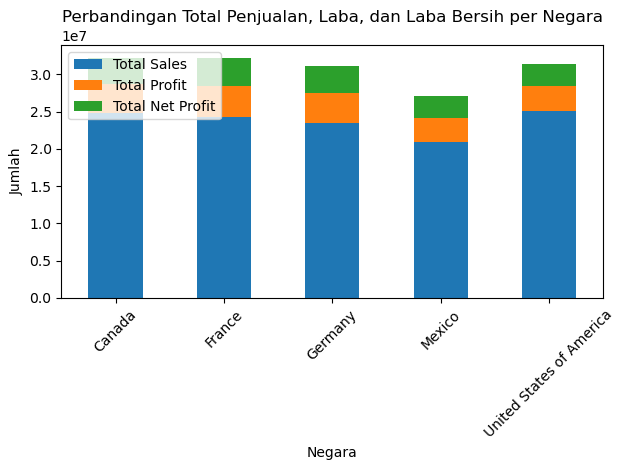

<Figure size 1200x600 with 0 Axes>

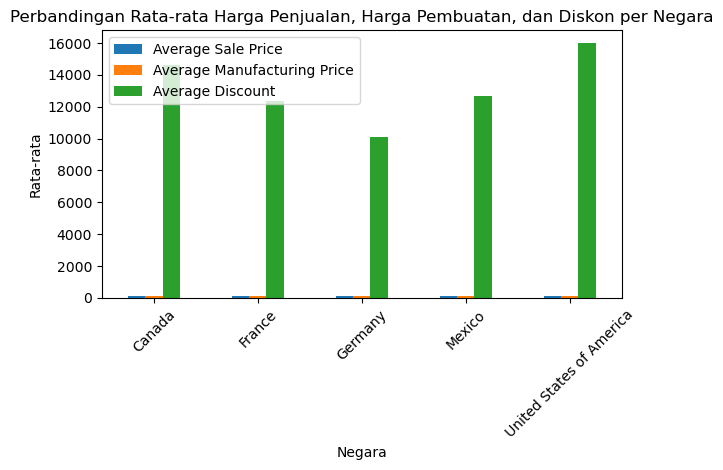

In [10]:
# Visualisasi Total Penjualan, Total Laba, dan Total Laba Bersih untuk setiap negara
plt.figure(figsize=(12, 6))
comparison_df[['Total Sales', 'Total Profit', 'Total Net Profit']].plot(kind='bar', stacked=True)
plt.title('Perbandingan Total Penjualan, Laba, dan Laba Bersih per Negara')
plt.xlabel('Negara')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Visualisasi Rata-rata Harga Penjualan, Harga Pembuatan, dan Diskon untuk setiap negara
plt.figure(figsize=(12, 6))
comparison_df[['Average Sale Price', 'Average Manufacturing Price', 'Average Discount']].plot(kind='bar')
plt.title('Perbandingan Rata-rata Harga Penjualan, Harga Pembuatan, dan Diskon per Negara')
plt.xlabel('Negara')
plt.ylabel('Rata-rata')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
#PROFIT MARGIN ANALAYSIS

# Menghitung margin keuntungan untuk setiap baris data
data['Profit Margin'] = ((data['Sale Price'] - data['COGS']) / data['Sale Price']) * 100
# Menghitung rata-rata margin keuntungan untuk setiap produk atau segmen
avg_profit_margin = data.groupby('Product')['Profit Margin'].mean()
# Menampilkan hasil analisis
avg_profit_margin

Product
 Amarilla     -107539.928065
 Carretera    -104606.198669
 Montana      -110598.795187
 Paseo        -111812.893682
 VTT          -102621.365662
 Velo         -102980.229358
Name: Profit Margin, dtype: float64

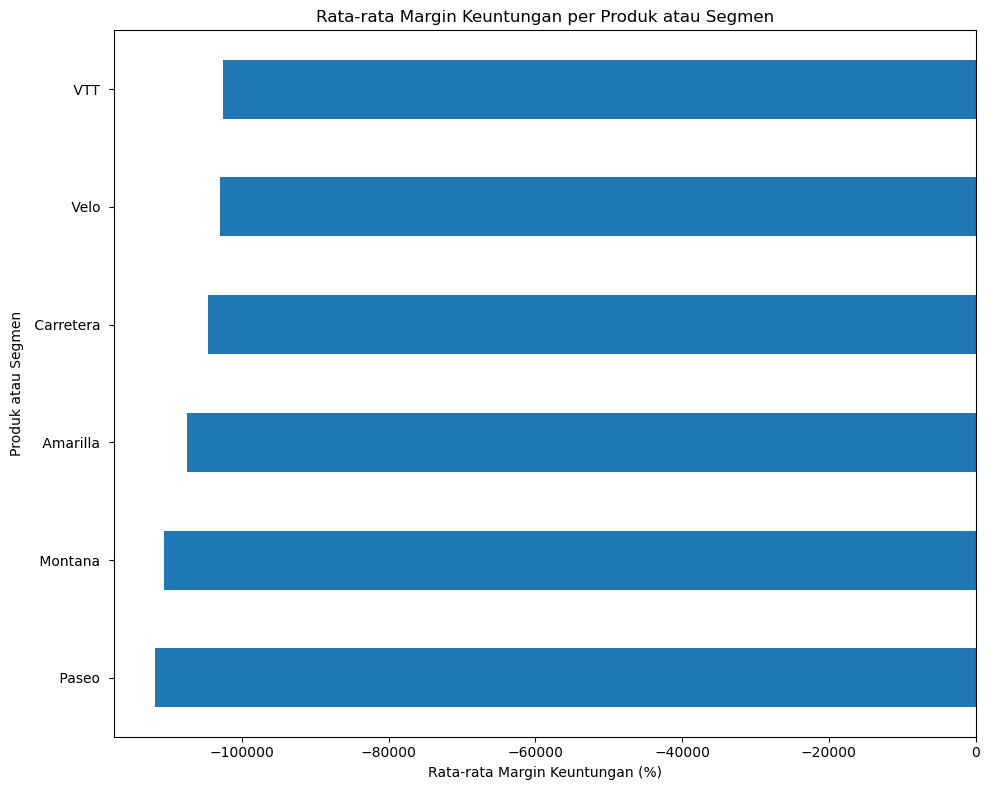

In [12]:
# Mengatur ukuran plot
plt.figure(figsize=(10, 8))

# Membuat diagram batang horizontal
avg_profit_margin.sort_values().plot(kind='barh')

# Menambahkan judul dan label sumbu
plt.title('Rata-rata Margin Keuntungan per Produk atau Segmen')
plt.xlabel('Rata-rata Margin Keuntungan (%)')
plt.ylabel('Produk atau Segmen')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [13]:
#DISCOUNT ANALYSIS
# Menghitung rata-rata diskon untuk setiap produk atau segmen
avg_discount = data.groupby('Product')['Discounts'].mean()

# Menampilkan hasil analisis diskon
avg_discount

Product
 Amarilla      13724.904255
 Carretera     12066.505376
 Montana       12462.483871
 Paseo         12873.564356
 VTT           13363.146789
 Velo          14464.954128
Name: Discounts, dtype: float64

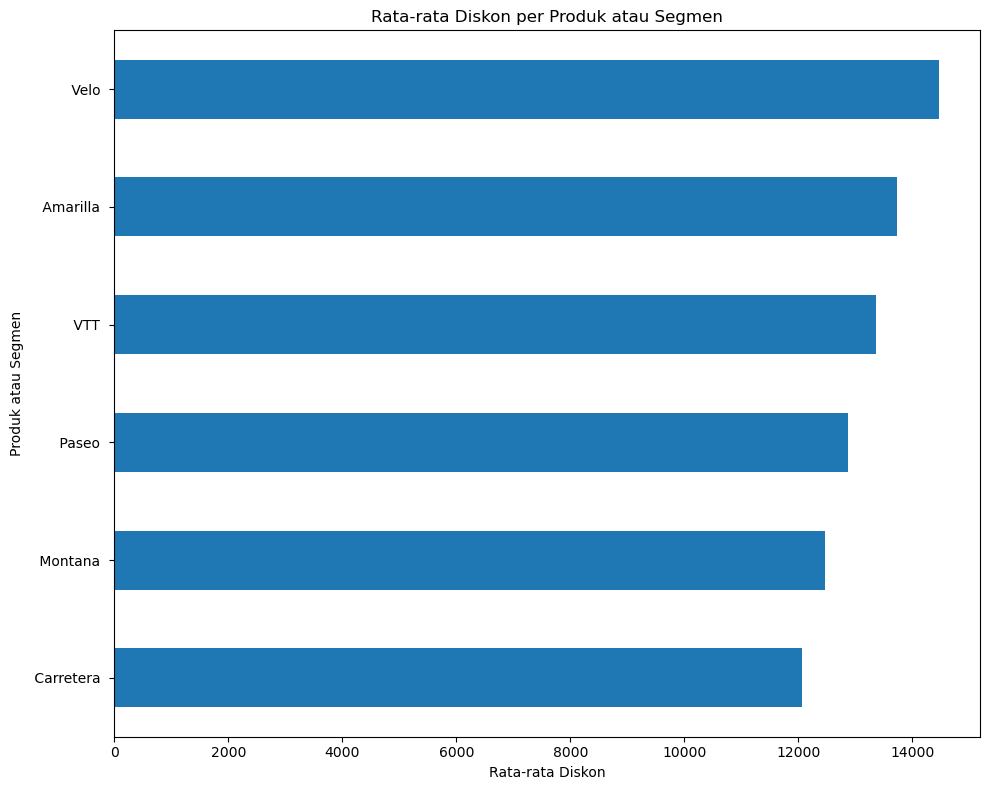

In [14]:
# Mengatur ukuran plot
plt.figure(figsize=(10, 8))

# Membuat diagram batang horizontal
avg_discount.sort_values().plot(kind='barh')

# Menambahkan judul dan label sumbu
plt.title('Rata-rata Diskon per Produk atau Segmen')
plt.xlabel('Rata-rata Diskon')
plt.ylabel('Produk atau Segmen')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [15]:
#ANALYSIS PROFIT
#Menghitung laba bersih untuk setiap transaksi
data['Net Profit'] = data['Sales'] - data['COGS']

# Menampilkan detail nama produk, perusahaan, dan laba bersih
product_details = data[['Product', 'Segment', 'Net Profit']]
print(product_details)

         Product           Segment  Net Profit
0     Carretera         Government       16185
1     Carretera         Government       13210
2     Carretera          Midmarket       10890
3     Carretera          Midmarket        4440
4     Carretera          Midmarket       12350
..           ...               ...         ...
695    Amarilla     Small Business       12375
696    Amarilla     Small Business        2730
697     Montana         Government        1299
698       Paseo         Government         686
699         VTT   Channel Partners       13003

[700 rows x 3 columns]


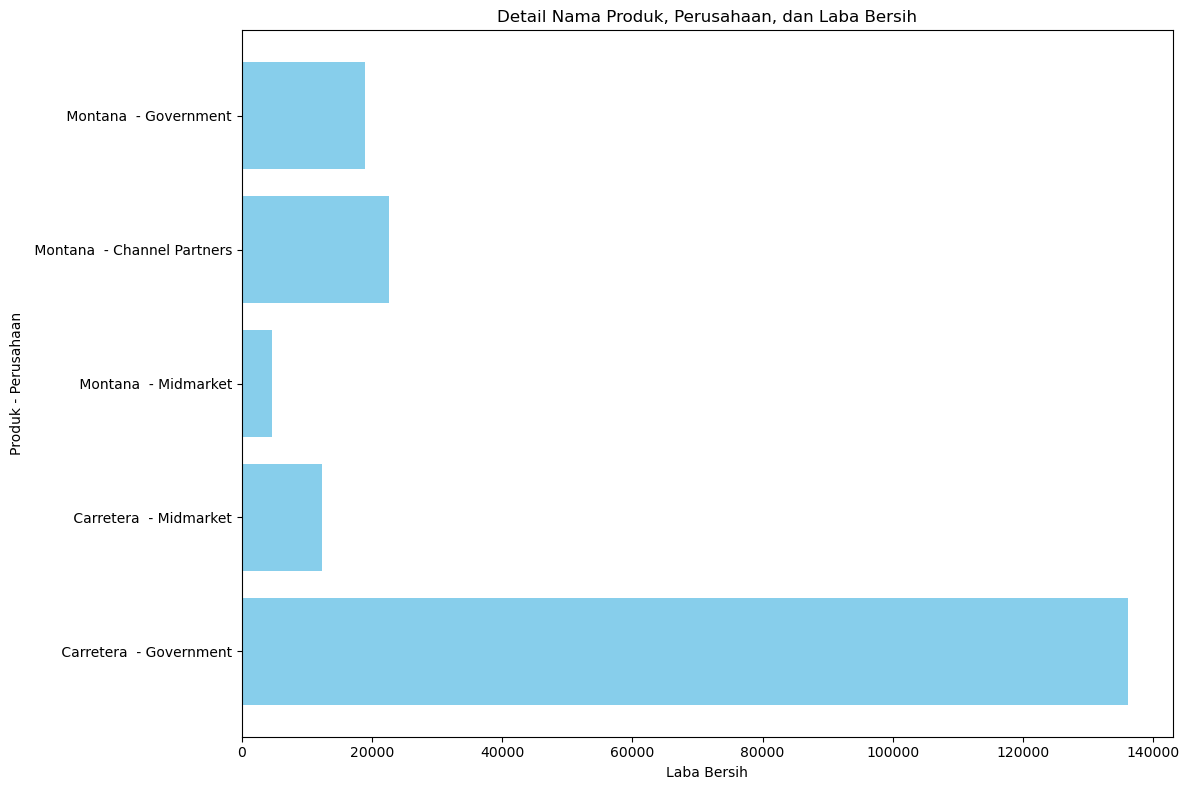

In [16]:
# Mengatur ukuran plot
plt.figure(figsize=(12, 8))

# Mengambil 10 data teratas untuk divisualisasikan
top_product_details = product_details.head(10)

# Membuat diagram batang horizontal
plt.barh(top_product_details['Product'] + ' - ' + top_product_details['Segment'], top_product_details['Net Profit'], color='skyblue')

# Menambahkan judul dan label sumbu
plt.title('Detail Nama Produk, Perusahaan, dan Laba Bersih')
plt.xlabel('Laba Bersih')
plt.ylabel('Produk - Perusahaan')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [17]:
# Memilih fitur-fitur yang relevan
features = ['Units Sold', 'Manufacturing Price', 'Sale Price', 'Gross Sales', 'Discounts', 'COGS', 'Profit']
target = ['Profit']

# Normalisasi data
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Membagi dataset menjadi fitur-fitur input dan target output
X = data[features].values
y = data[target].values

# Membagi data menjadi set pelatihan, validasi, dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Membangun model jaringan saraf tiruan
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Kompilasi model
model.compile(optimizer='adam', loss='mse')

# Melatih model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# Evaluasi model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

# Melakukan prediksi
predictions = model.predict(X_test)

# Menampilkan hasil prediksi
for i in range(10):
    print("Predicted Profit:", predictions[i][0], "Actual Profit:", y_test[i][0])

Epoch 1/50
14/14 [==============================] - 0s 10ms/step - loss: 0.7565 - val_loss: 0.6234
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.4954 - val_loss: 0.4014
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.3159 - val_loss: 0.2427
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1999 - val_loss: 0.1234
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1017 - val_loss: 0.0359
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0260
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0170 - val_loss: 0.0142
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 11/50
14/14 

Hasil Evaluasi Kinerja Model:
                                  Metric     Value
0              Mean Absolute Error (MAE)  0.009693
1  Mean Absolute Percentage Error (MAPE)  2.665659
2            Prediction Error Percentage  2.665659


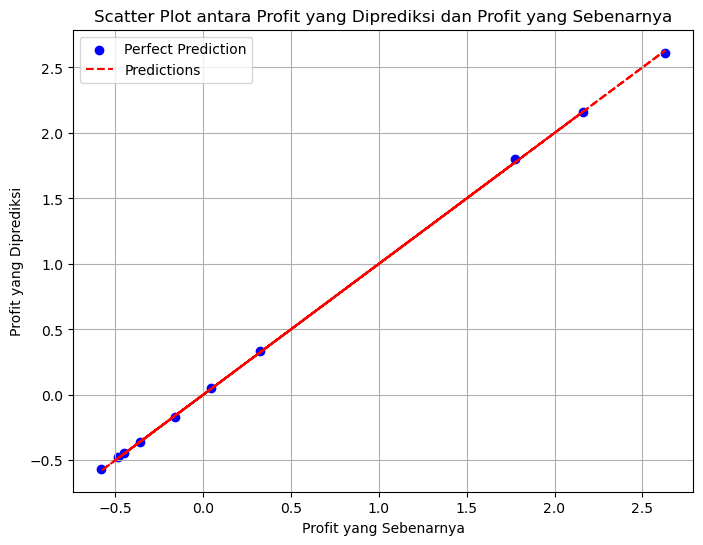

In [20]:
# Hasil prediksi profit yang diprediksi
predicted_profit = [0.0516702, -0.44479153, -0.3586135, 1.8005819, -0.56370765,
                    2.6073287, -0.16600099, -0.47536334, 2.1613226, 0.33287895]

# Hasil profit yang sebenarnya
actual_profit = [0.04576441874296353, -0.45018593501987564, -0.3594553554702568,
                 1.774500820624878, -0.5789383282572208, 2.627551855293472,
                 -0.16142306283240404, -0.48509160260485945, 2.1618933403898506,
                 0.32450247982471314]


# Menghitung metrik evaluasi
mae = mean_absolute_error(actual_profit, predicted_profit)

# Menghitung Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(np.array(actual_profit), np.array(predicted_profit))

# Menghitung Persentase Kesalahan Prediksi (Prediction Error Percentage)
error_percentage = np.mean(np.abs((np.array(actual_profit) - np.array(predicted_profit)) / np.array(actual_profit))) * 100

# Membuat dataframe untuk menampilkan hasil evaluasi
evaluation_results = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Absolute Percentage Error (MAPE)', 'Prediction Error Percentage'],
    'Value': [mae, mape, error_percentage]
})

# Menampilkan hasil evaluasi
print("Hasil Evaluasi Kinerja Model:")
print(evaluation_results)

# Visualisasi scatter plot antara profit yang diprediksi dan profit yang sebenarnya
plt.figure(figsize=(8, 6))
plt.scatter(actual_profit, predicted_profit, color='blue')
plt.plot(actual_profit, actual_profit, color='red', linestyle='--')
plt.title('Scatter Plot antara Profit yang Diprediksi dan Profit yang Sebenarnya')
plt.xlabel('Profit yang Sebenarnya')
plt.ylabel('Profit yang Diprediksi')
plt.grid(True)
plt.legend(['Perfect Prediction', 'Predictions'])
plt.show()

In [23]:
forecast = data[['Date', 'Profit']]
forecast

,Date,Profit
0,01/01/2014,-0.245656
1,01/01/2014,-0.317520
2,01/06/2014,-0.373563
3,01/06/2014,-0.529370
4,01/06/2014,-0.338295
...,...,...
695,01/03/2014,-0.337691
696,01/10/2014,-0.570677
697,01/02/2014,-0.605244
698,01/04/2014,-0.620052


In [117]:
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

# Fungsi untuk membagi data menjadi sekuens data LSTM
def create_sequences(forecast, seq_length):
    X, y = [], []
    for i in range(len(forecast)-seq_length):
        X.append(forecast[i:i+seq_length])
        y.append(forecast[i+seq_length])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(forecast[['Profit']])

# Membagi data menjadi data latih dan data uji
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Membuat sekuens data untuk model LSTM
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Inisialisasi list untuk menyimpan RMSE dari setiap lipatan validasi
combined_rmse_scores = []

# Menggunakan KFold untuk validasi silang
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Inisialisasi ulang model XGBoost pada setiap lipatan
    model_xgb = XGBRegressor(n_estimators=100, max_depth=3)

    # Melatih model XGBoost
    model_xgb.fit(X_train_fold.reshape(X_train_fold.shape[0], X_train_fold.shape[1]), y_train_fold)

    # Melakukan prediksi menggunakan model XGBoost pada data validasi
    xgb_val_predictions = model_xgb.predict(X_val_fold.reshape(X_val_fold.shape[0], X_val_fold.shape[1]))

    # Membangun model LSTM
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=50, activation='elu', input_shape=(seq_length, 1)))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer='adadelta', loss='mean_squared_error')

    # Melatih model LSTM
    model_lstm.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32, verbose=0)

    # Melakukan prediksi menggunakan model LSTM pada data validasi
    lstm_val_predictions = model_lstm.predict(X_val_fold)

    # Mengubah bentuk prediksi LSTM menjadi 1D array
    lstm_val_predictions = lstm_val_predictions.reshape(-1)

    # Menggabungkan prediksi dari model LSTM dan XGBoost
    combined_val_predictions = (lstm_val_predictions + xgb_val_predictions) / 2

    # Menghitung RMSE untuk setiap lipatan validasi
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, combined_val_predictions))
    combined_rmse_scores.append(rmse_fold)

# Menampilkan RMSE rata-rata dari validasi silang
print("Average RMSE from Cross Validation:", np.mean(combined_rmse_scores))

# Melatih model LSTM pada seluruh data latih
model_lstm.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# Melakukan prediksi menggunakan model LSTM pada data uji
lstm_predictions = model_lstm.predict(X_test)

# Mengubah bentuk prediksi LSTM menjadi 1D array
lstm_predictions = lstm_predictions.reshape(-1)

# Membangun model XGBoost
model_xgb = XGBRegressor(n_estimators=100, max_depth=3)

# Melatih model XGBoost
model_xgb.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)

# Melakukan prediksi menggunakan model XGBoost pada data uji
xgb_predictions = model_xgb.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))

# Menggabungkan prediksi dari model LSTM dan XGBoost
combined_predictions = (lstm_predictions + xgb_predictions) / 2

# Menghitung RMSE
rmse = np.sqrt(mean_squared_error(y_test, combined_predictions))
print("Root Mean Squared Error (RMSE) on Test Data:", rmse)


4/4 [==============================] - 0s 926us/step
Average RMSE from Cross Validation: 0.17852334296837324
5/5 [==============================] - 0s 1ms/step
Root Mean Squared Error (RMSE) on Test Data: 0.09447281065899629
